In [1]:
# Cell 1: Imports and DataPreprocessor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import pickle
import warnings
warnings.filterwarnings('ignore')

class DataPreprocessor:
    """
    A class to handle all data preprocessing steps for the hotel booking dataset
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.features = None
        self.categorical_columns = ['type_of_meal_plan', 'room_type_reserved', 
                                        'market_segment_type', 'booking_status']
    
    def load_data(self, filepath):
        """Load the dataset from CSV file"""
        self.data = pd.read_csv(filepath)
        return self.data
    
    def handle_missing_values(self):
        """Handle missing values in the dataset"""
        # Get numeric columns
        numeric_columns = self.data.select_dtypes(include=['float64', 'int64']).columns
        
        # Impute missing values with mean for numeric columns
        numeric_imputer = SimpleImputer(strategy='mean')
        self.data[numeric_columns] = numeric_imputer.fit_transform(self.data[numeric_columns])
        
        return self.data
    
    def create_features(self):
        """Create new features from existing ones"""
        # Total nights
        self.data['total_nights'] = (self.data['no_of_weekend_nights'] + 
                                    self.data['no_of_week_nights'])
        
        # Total guests
        self.data['total_guests'] = self.data['no_of_adults'] + self.data['no_of_children']
        
        # Total previous bookings
        self.data['total_previous_bookings'] = (self.data['no_of_previous_cancellations'] + 
                                                self.data['no_of_previous_bookings_not_canceled'])
        
        return self.data
    
    def encode_categorical(self):
        """Encode categorical variables"""
        for column in self.categorical_columns:
            self.data[column + '_encoded'] = self.label_encoder.fit_transform(self.data[column])
        return self.data
    
    def select_features(self):
        """Select features for model training"""
        self.features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 
                        'no_of_week_nights', 'required_car_parking_space', 'lead_time',
                        'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest',
                        'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
                        'avg_price_per_room', 'no_of_special_requests', 'total_nights',
                        'total_guests', 'total_previous_bookings', 'type_of_meal_plan_encoded',
                        'room_type_reserved_encoded', 'market_segment_type_encoded']
        
        X = self.data[self.features]
        y = self.data['booking_status_encoded']
        
        return X, y
    
    def scale_features(self, X_train, X_test):
        """Scale the features using StandardScaler"""
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Convert to DataFrame to keep feature names
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
        
        return X_train_scaled, X_test_scaled
    
    def save_preprocessor(self, filepath):
        """Save the preprocessor object"""
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)

In [2]:
# Cell 2: ModelTrainer
class ModelTrainer:
    """
    A class to handle model training and evaluation
    """
    def __init__(self):
        self.rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.xgb_model = XGBClassifier(random_state=42)
        self.features = None
    
    def train_random_forest(self, X_train, y_train):
        """Train Random Forest model"""
        self.rf_model.fit(X_train, y_train)
        return self.rf_model
    
    def train_xgboost(self, X_train, y_train):
        """Train XGBoost model"""
        self.xgb_model.fit(X_train, y_train)
        return self.xgb_model
    
    def evaluate_model(self, model, X_test, y_test, model_name):
        """Evaluate model performance"""
        predictions = model.predict(X_test)
        
        print(f"\n{model_name} Model Evaluation:")
        print("\nAccuracy Score:", accuracy_score(y_test, predictions))
        print("\nClassification Report:")
        print(classification_report(y_test, predictions))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return predictions
    
    def plot_feature_importance(self, model, features, model_name):
        """Plot feature importance"""
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
        plt.title(f'Top 10 Most Important Features ({model_name})')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()
        
        return feature_importance
    
    def compare_models(self, X_train, X_test, y_train, y_test, features):
        """Compare Random Forest and XGBoost models"""
        # Train both models
        rf_pred = self.evaluate_model(self.rf_model, X_test, y_test, "Random Forest")
        xgb_pred = self.evaluate_model(self.xgb_model, X_test, y_test, "XGBoost")
        
        # Cross-validation comparison
        cv_scores_rf = cross_val_score(self.rf_model, X_train, y_train, cv=5)
        cv_scores_xgb = cross_val_score(self.xgb_model, X_train, y_train, cv=5)
        
        print("\nModel Comparison:")
        print("\n1. Random Forest vs XGBoost Accuracy:")
        print(f"Random Forest: {accuracy_score(y_test, rf_pred):.4f}")
        print(f"XGBoost: {accuracy_score(y_test, xgb_pred):.4f}")
        
        print("\n2. Cross-validation scores (5-fold):")
        print(f"Random Forest: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")
        print(f"XGBoost: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")
        
        # Feature importance comparison
        rf_importance = self.plot_feature_importance(self.rf_model, features, "Random Forest")
        xgb_importance = self.plot_feature_importance(self.xgb_model, features, "XGBoost")
        
        return {
            'rf_accuracy': accuracy_score(y_test, rf_pred),
            'xgb_accuracy': accuracy_score(y_test, xgb_pred),
            'rf_cv_mean': cv_scores_rf.mean(),
            'xgb_cv_mean': cv_scores_xgb.mean(),
            'rf_cv_std': cv_scores_rf.std(),
            'xgb_cv_std': cv_scores_xgb.std()
        }
    
    def save_models(self, rf_path, xgb_path):
        """Save both models"""
        with open(rf_path, 'wb') as file:
            pickle.dump(self.rf_model, file)
        with open(xgb_path, 'wb') as file:
            pickle.dump(self.xgb_model, file)

Loading and preprocessing data...

Training models...

Comparing models...

Random Forest Model Evaluation:

Accuracy Score: 0.9037904893177119

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2416
           1       0.91      0.95      0.93      4839

    accuracy                           0.90      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255


Comparing models...

Random Forest Model Evaluation:

Accuracy Score: 0.9037904893177119

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2416
           1       0.91      0.95      0.93      4839

    accuracy                           0.90      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255



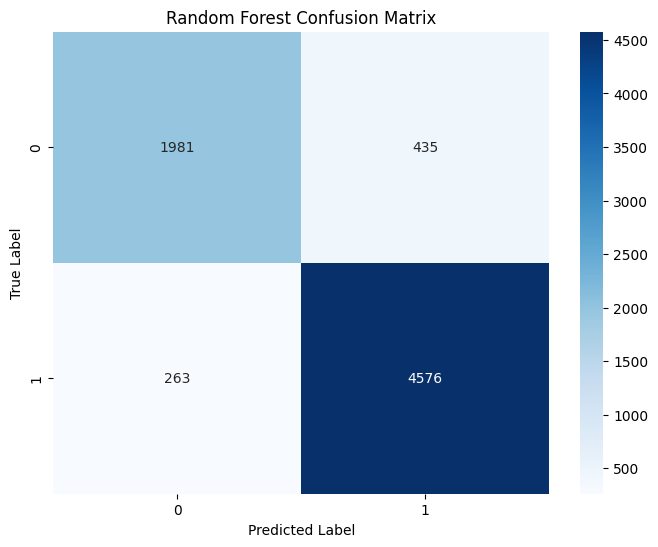


XGBoost Model Evaluation:

Accuracy Score: 0.8882150241212956

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      2416
           1       0.90      0.93      0.92      4839

    accuracy                           0.89      7255
   macro avg       0.88      0.87      0.87      7255
weighted avg       0.89      0.89      0.89      7255



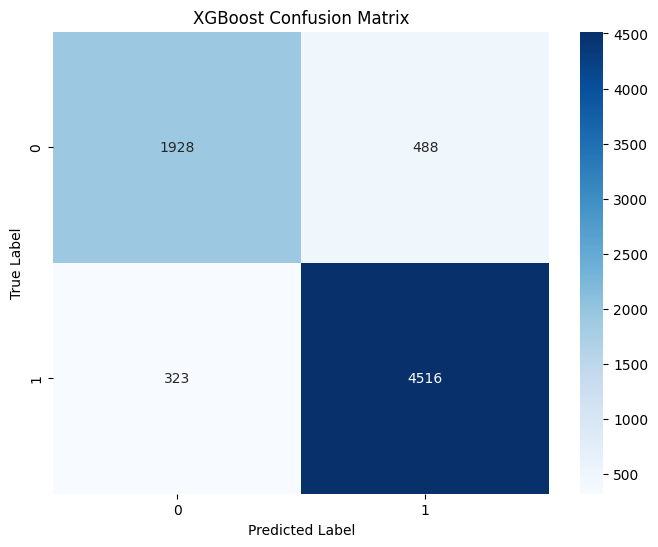


Model Comparison:

1. Random Forest vs XGBoost Accuracy:
Random Forest: 0.9038
XGBoost: 0.8882

2. Cross-validation scores (5-fold):
Random Forest: 0.8952 (+/- 0.0100)
XGBoost: 0.8879 (+/- 0.0077)


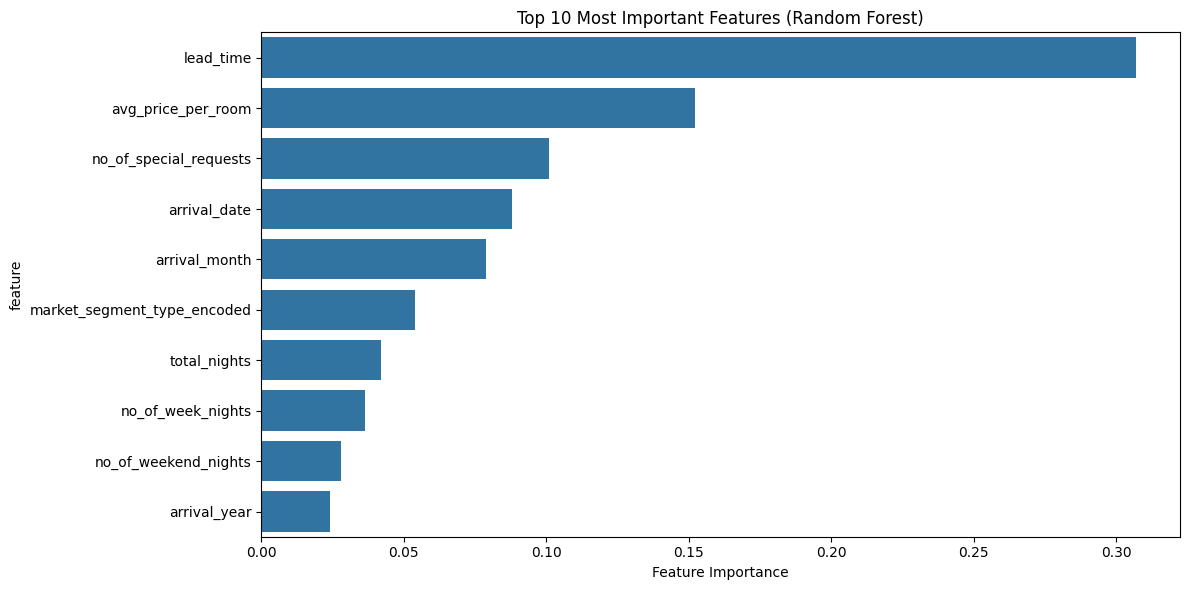

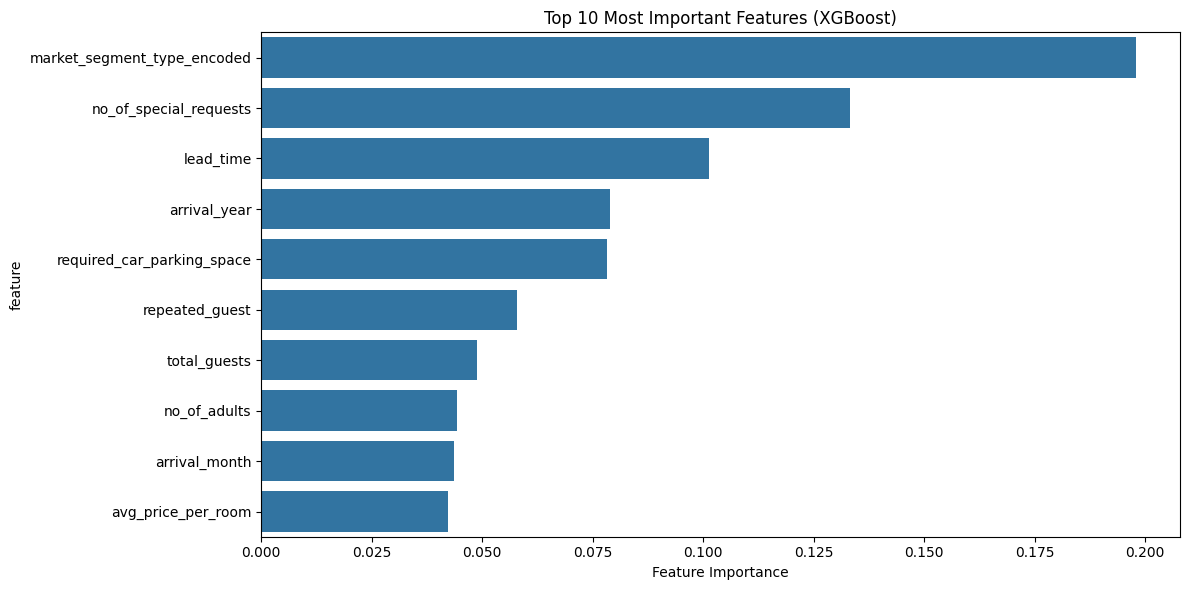


All processing completed successfully!


In [3]:
# Cell 3: Main execution
if __name__ == "__main__":
    # Initialize preprocessor
    preprocessor = DataPreprocessor()
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    data = preprocessor.load_data('Dataset_B_hotel.csv')
    data = preprocessor.handle_missing_values()
    data = preprocessor.create_features()
    data = preprocessor.encode_categorical()
    
    # Get features and target
    X, y = preprocessor.select_features()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    X_train_scaled, X_test_scaled = preprocessor.scale_features(X_train, X_test)
    
    # Save preprocessor
    preprocessor.save_preprocessor('preprocessor.pkl')
    
    # Initialize and train models
    print("\nTraining models...")
    trainer = ModelTrainer()
    trainer.train_random_forest(X_train_scaled, y_train)
    trainer.train_xgboost(X_train_scaled, y_train)
    
    # Compare models
    print("\nComparing models...")
    comparison_results = trainer.compare_models(X_train_scaled, X_test_scaled, 
                                                y_train, y_test, preprocessor.features)
    
    # Save models
    trainer.save_models('random_forest_model_oop.pkl', 'xgboost_model_oop.pkl')
    
    # Save comparison results
    with open('model_comparison_results_oop.pkl', 'wb') as file:
        pickle.dump(comparison_results, file)
    
    print("\nAll processing completed successfully!")